# Intro
In this notebook, I will try to preproccess the data with higher resolution and use data augmantation for normalizing and centerizing the pixels.
As before:
* dog: y = 1
* cat: y = 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm      # a nice pretty percentage bar for tasks.
from random import shuffle

Getting the images' file names.

In [15]:
TRAIN_DIR = '../input/train/'
TRAIN_DIR_DOG = '../input/train/dog/' 
TRAIN_DIR_CAT = '../input/train/cat/'

VAL_DIR = '../input/validation/'
VAL_DIR_DOG = '../input/validation/dog/'
VAL_DIR_CAT = '../input/validation/cat/'
ROWS = 256
COLS = 256
CHANNELS = 3
IMG_COUNT = 12500

dog_train_list = [TRAIN_DIR_DOG+name for i,name in enumerate(os.listdir(TRAIN_DIR_DOG)) if i < IMG_COUNT]
cat_train_list = [TRAIN_DIR_CAT+name for i,name in enumerate(os.listdir(TRAIN_DIR_CAT)) if i < IMG_COUNT]

dog_val_list = [VAL_DIR_DOG+name for name in os.listdir(VAL_DIR_DOG)]
cat_val_list = [VAL_DIR_CAT+name for name in os.listdir(VAL_DIR_CAT)]

shuffle(dog_train_list)
shuffle(cat_train_list)

shuffle(dog_val_list)
shuffle(cat_val_list)

print(len(dog_train_list)+len(cat_train_list))
print(len(dog_val_list) + len(dog_val_list))

20000
5000


## Spliting the data into training and validation sets

In [5]:
# data_file_names ={}
# data_labels={}

# dog_train_img, dog_val_img, \
# dog_train_labels, dog_val_labels = train_test_split(dog_image_list, dog_labels,
#                   test_size=0.2, random_state=2)

# cat_train_img, cat_val_img, \
# cat_train_labels, cat_val_labels = train_test_split(cat_image_list, cat_labels,
#                   test_size=0.2, random_state=2)

# data_file_names['train'] = dog_train_img + cat_train_img
# data_labels['train'] = dog_train_labels + cat_train_labels
# data_file_names['val'] = dog_val_img + cat_val_img
# data_labels['val'] = dog_val_labels + cat_val_labels

# print("Training Set:\t\t\tValidation Set:")
# print("Total Images: {}\t\tTotal Images: {}".format(len([i for i in data_labels['train']]),
#                                                       len([i for i in data_labels['val']])))
# print("Dogs' Images: {}\t\tDogs' Images: {}".format(len([i for i in data_labels['train'] if i == 1]),
#                                                     len([i for i in data_labels['val'] if i == 1])))
# print("Cats' Images: {}\t\tCats' Images: {}".format(len([i for i in data_labels['train'] if i == 0]),
#                                                     len([i for i in data_labels['val'] if i == 0])))

# Defining the data augmantation generator

We're going to let him read files from the directory and split the data into training and validation sets.
In order to pre calculate the std_dev and mean, we will sample 10% of the data for those calculations.

In [12]:
train_aug_gen = ImageDataGenerator(featurewise_center=True)
val_aug_gen = ImageDataGenerator(featurewise_center=True)


def load_image(file_path, size=(ROWS,COLS)):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    return cv2.resize(rgb_img, (ROWS,COLS))
    

def load_image_list(file_list, ret_labels=True):
    count = len(file_list)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    labels = []
    
    for i, image_name in tqdm(enumerate(file_list)):
        data[i] = load_image(image_name)
        if 'dog' in image_name:
            labels.append(1)
        else:
            labels.append(0)
    if ret_labels:
        return data, labels
    else:
        return data

PREPROCESS_COUNT_TRAIN = int(len(dog_train_list) * 0.1)
PREPROCESS_COUNT_VAL = int(len(dog_val_list) * 0.1)

preprocess_dogs = dog_train_list[0:PREPROCESS_COUNT_TRAIN]
preprocess_cats = cat_train_list[0:PREPROCESS_COUNT_TRAIN]
preprocess_list = preprocess_cats + preprocess_dogs

train_aug_gen.fit(load_image_list(preprocess_list,False))

preprocess_dogs = dog_val_list[0:PREPROCESS_COUNT_VAL]
preprocess_cats = cat_val_list[0:PREPROCESS_COUNT_VAL]
preprocess_list = preprocess_cats + preprocess_dogs

val_aug_gen.fit(load_image_list(preprocess_list,False))

2000it [00:10, 186.95it/s]
500it [00:02, 183.37it/s]


In [13]:
model = Sequential()

# BLOC 1
model.add(Conv2D(filters=16, kernel_size=(4,4), padding='Same', activation='relu', input_shape=(ROWS,COLS,CHANNELS)))
model.add(Conv2D(filters=16, kernel_size=(4,4), padding='Same', activation='relu'))
# model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(rate=0.5))

# BLOC 2
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(4,4), padding='Same', activation='relu'))
# model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(rate=0.5))

# BLOC 3
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(4,4), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Dropout(rate=0.5))

# BLOC 4 size of 16x16
model.add(Flatten())
# model.add(Dense(1024, activation='relu', kernel_regularizer=regl2))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # check if we could use softmax function instead

optimizer = SGD(lr=0.01,
#                 decay=0.01
               )
# optimizer = Adam(lr=0.01)

In [17]:
filepath = 'cat_dog_aug_generator_v1'

retrain = True

if filepath in os.listdir() and not retrain:
    print('Loading model from disk..')
    model = load_model(filepath)
    
else:
    print('Compiling Model..')
    model.compile(optimizer=optimizer, loss="binary_crossentropy",
              metrics=["accuracy"])

    print(model.summary())

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5)

checkpoint = ModelCheckpoint(filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=False,
                            mode='min')



Compiling Model..
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 16)      784       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 16)      4112      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        8224      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0  

In [ ]:
epochs = 1

history = model.fit_generator(generator=train_aug_gen.flow_from_directory(TRAIN_DIR, 
                                                                          class_mode='binary', 
                                                                          target_size=(ROWS,COLS)),
                              validation_data=val_aug_gen.flow_from_directory(VAL_DIR,
                                                                              class_mode='binary',
                                                                              target_size=(ROWS,COLS)),
                              verbose=2,
                              epochs=epochs,
                              callbacks=[checkpoint, early_stop])

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/1


KeyboardInterrupt: 

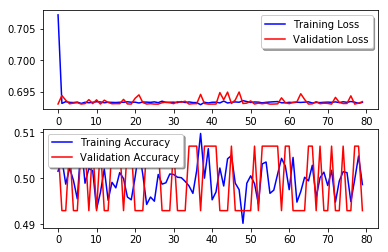

In [10]:
fig, ax = plt.subplots(2,1)
# Loss Plot
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')

legend = ax[0].legend(loc='best', shadow=True)

# Accuracy Plot
ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)